# Simulations of the Shock and Degradation Model

This code written by Ryan White is used in the paper:

Jewgeni H. Dshalalow and Ryan T. White (2021). Random Walk Analysis in a Reliability System Under Constant Degradation and Random Shocks. [accepted at *Axioms*].

## Exponential $\delta_i$ and $X_i$

Assume $X_i$'s are *i.i.d.* with exponential($\lambda$) and $\delta_i$'s are independent of $X_i$'s and *i.i.d* exponential($\mu$).

* Note that the `numpy` implementation of exponential random number generator uses the inverse of the parameter we use.
* We will write a function that simulates one path of the process to be re-called in Monte Carlo simulation.
* The function will take inputs:
 * The parameter of the jumps $\lambda$ (called `lam` to avoid the Python reserved command `lambda`)
 * The parameter of the times between shocks $\mu$ (`mu`)
 * The decay rate $a$ (`a`)
 * The threshold $M$ (`M`)
* The function will return:
 * The cause of failure (shock or degradation)
 * The times $t_{\nu-1}$ and $t_\nu$
 * The damage at time $t_{\nu-1}$
 * The damage at time $\tau_\nu$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def simulatePath(a, lam, mu, M):
    # initialize outputs
    failureTime = 0
    failureDamage = 0
    failureIndex = 0
    degradationFailure = False

    # simulate the process
    while failureDamage < M:
        # save A_j-1
        oldDamage = failureDamage

        # save t_j-1
        oldTime = failureTime

        # compute waiting time before the next shock
        waitingTime = np.random.exponential(1/mu)

        # add decay between shocks
        failureDamage += a * waitingTime

        # if decay causes damage to reach M...
        if failureDamage >= M:
            # compute tau_nu
            failureTime += (M - oldDamage)/a

            # set S_nu (total damage) to M
            failureDamage = M

            # mark decay as the cause of the exit
            degradationFailure = True

            # exit the loop
            break

        # else, add the shock
        else:
            # add the waiting time
            failureTime += waitingTime

            # add the shock damage
            failureDamage += np.random.exponential(1/lam)

            # add 1 to the shock counter
            failureIndex += 1

    # gather the output values into a tuple
    outputs = (failureIndex, oldDamage, failureDamage,
               oldTime, failureTime, degradationFailure)

    # return values nu, A_nu-1, S_nu, t_nu-1, tau_nu, flag for exit type
    return outputs

def degradationProbability(a, lam, mu, M):
    return (a * lam + mu * np.exp(-(lam + mu / a) * M)) / (a * lam + mu)

def failureTimeMean(a, lam, mu, M):
    return (lam * M + 1 - decayProbability(a, lam, mu, M)) / (a * lam + mu)

def failureTimeVariance(a, lam, mu, M):
    dTerm = a * lam + mu
    eTerm = np.exp(-(lam + mu / a) * M)
    term1 = 2 * lam * mu * M / dTerm ** 3
    term2 = mu * (mu - 4 * a * lam) / dTerm ** 4
    term3 = 2 * mu * (2 * a ** 2 * lam + a ** 2 * lam ** 2 * M - 2 * mu ** 2 * M)
    term3 *= eTerm / (a * dTerm ** 4)
    term4 = 2 * mu ** 2 * eTerm ** 2 / dTerm ** 4
    return term1 + term2 + term3 - term4

def failureDamageMean(a, lam, mu, M):
    return M + (1 - decayProbability(a, lam, mu, M)) / lam

def failureDamageVariance(a, lam, mu, M):
    dTerm = a * lam + mu
    eTerm = np.exp(-(lam + mu / a) * M)
    term1 = 2 * a * mu * (1 - eTerm) / (lam * dTerm ** 2)
    term2 = mu ** 2 * (1 - eTerm ** 2) / (lam * dTerm) ** 2
    return term1 + term2

Let's test it!

In [2]:
simulatePath(1,1,2,100)

(66, 99.82563986629172, 100, 34.897929023222666, 35.07228915693094, True)

Let's compute empirical means of each of the terms...

In [10]:
a = 0.01
lam = 2
mu = 2
M = 10

results = []

print('Running simulations...\n')

for i in range(10000):
    results.append(simulatePath(a, lam, mu, M))
    if i % 1000 == 0: print('Iteration', i)
    
results = np.array(results)

print('\nComputing empirical mean and variance...\n')

means = np.mean(results[:, [2, 4, 5]],0)
var = np.var(results[:, [2, 4]], 0)

empiricalResults = np.array([means[0], var[0], means[1], var[1], means[2]])

print('Computing predicted results...\n')

predictedResults = np.array([failureTimeMean(a, lam, mu, M),
                             failureTimeVariance(a, lam, mu, M),
                             failureDamageMean(a, lam, mu, M),
                             failureDamageVariance(a, lam, mu, M),
                             degradationProbability(a, lam, mu, M)])

print('Empirical Results', np.round(empiricalResults, 2), '\n')
print('Predicted Results', np.round(predictedResults, 2))

Running simulations...

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000

Computing empirical mean and variance...

Computing predicted results...

Empirical Results [1.050e+01 2.600e-01 1.036e+01 1.005e+01 1.000e-02] 

Predicted Results [1.050e+01 2.500e-01 1.039e+01 9.940e+00 1.000e-02]


Let's do the same but iterate over $a$ values.

In [4]:
lam = 2
mu = 3

maxA = 10
maxM = 50

aSteps = 50

mList = [1, 5, 10, 25]

mSteps = len(mList)

aSpace = np.linspace(0.1, maxA + 0.1, aSteps)
mSpace = np.linspace(1, maxM + 1, mSteps)

empiricalCarrier = []
predictedCarrier = []

for M in mList:
    print('Threhold', M)
    
    empirical = []
    predicted = []
    
    for a in aSpace:
        print('Degradation rate', a)

        results = []

        #print('Running simulations...')

        for i in range(10000):
            results.append(simulatePath(a, lam, mu, M))
            # if i % 1000 == 0: print('Iteration', i)

        results = np.array(results)

        means = np.mean(results[:, [2, 4, 5]],0)
        var = np.var(results[:, [2, 4]], 0)

        empiricalResults = np.array([means[0], var[0], means[1], var[1], means[2]])

        empirical.append(empiricalResults)

        predictedResults = np.array([failureTimeMean(a, lam, mu, M),
                             failureTimeVariance(a, lam, mu, M),
                             failureDamageMean(a, lam, mu, M),
                             failureDamageVariance(a, lam, mu, M),
                             degradationProbability(a, lam, mu, M)])

        predicted.append(predictedResults)

        #print('Empirical Results', np.round(empiricalResults, 2))
        #print('Predicted Results', np.round(predictedResults, 2))
        
    # save the results from the previous step
    empiricalCarrier.append(empirical)
    predictedCarrier.append(predicted)

Threhold 1
Degradation rate 0.1
Degradation rate 0.3040816326530612
Degradation rate 0.5081632653061224
Degradation rate 0.7122448979591837
Degradation rate 0.9163265306122449
Degradation rate 1.1204081632653062
Degradation rate 1.3244897959183675
Degradation rate 1.5285714285714287
Degradation rate 1.73265306122449
Degradation rate 1.9367346938775512
Degradation rate 2.1408163265306124
Degradation rate 2.344897959183674
Degradation rate 2.548979591836735
Degradation rate 2.753061224489796
Degradation rate 2.9571428571428573
Degradation rate 3.1612244897959187
Degradation rate 3.3653061224489798
Degradation rate 3.5693877551020408
Degradation rate 3.773469387755102
Degradation rate 3.9775510204081637
Degradation rate 4.181632653061224
Degradation rate 4.385714285714285
Degradation rate 4.589795918367347
Degradation rate 4.793877551020408
Degradation rate 4.997959183673469
Degradation rate 5.20204081632653
Degradation rate 5.406122448979591
Degradation rate 5.610204081632653
Degradation

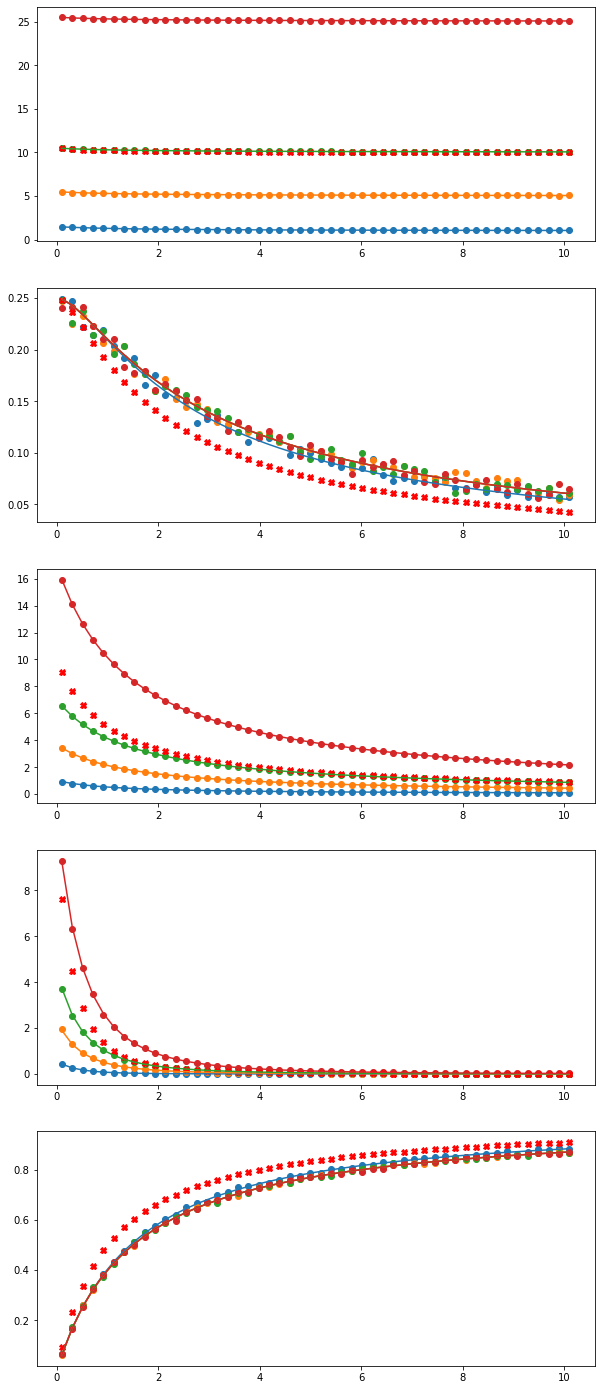

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots(5, figsize = (10, 25))

posVarLim = (2 * aSpace * mu * lam + mu ** 2) / (lam * (aSpace * lam + mu)) ** 2
timeVarLim = (2 * lam * mu * M * (aSpace * lam + mu) + mu * (mu - 4 * aSpace * lam)) / (aSpace * lam + mu) ** 4
probLim = aSpace * lam / (aSpace * lam + mu)

axs[0].plot(aSpace, M + (1 / lam) * mu / (aSpace * lam + mu), 'Xr')
axs[1].plot(aSpace, posVarLim, 'Xr')
axs[2].plot(aSpace, lam * M / (aSpace * lam + mu), 'Xr')
axs[3].plot(aSpace, timeVarLim, 'Xr')
axs[4].plot(aSpace, probLim, 'Xr')

for i in range(mSteps):
    empiricalArray = np.array(empiricalCarrier[i])
    predictedArray = np.array(predictedCarrier[i])
    
    # mean crossing position
    axs[0].scatter(aSpace, empiricalArray[:,0])
    axs[0].plot(aSpace, predictedArray[:,0])

    # variance of crossing position
    axs[1].scatter(aSpace, empiricalArray[:,1])
    axs[1].plot(aSpace, predictedArray[:,1])

    # mean crossing time
    axs[2].scatter(aSpace, empiricalArray[:,2])
    axs[2].plot(aSpace, predictedArray[:,2])

    # variance of crossing time
    axs[3].scatter(aSpace, empiricalArray[:,3])
    axs[3].plot(aSpace, predictedArray[:,3])

    # probability of decay exit
    axs[4].scatter(aSpace, empiricalArray[:,4])
    axs[4].plot(aSpace, predictedArray[:,4])

Text(0.5, 0.98, 'Probability of Degradation Crossing')

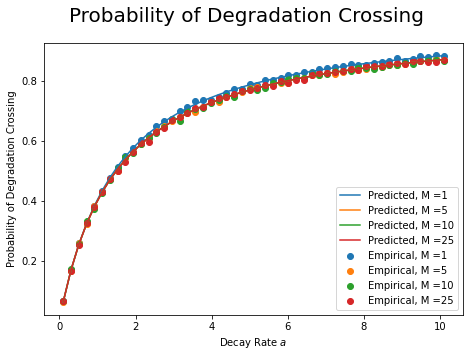

In [12]:
fig, (ax1) = plt.subplots(1, 1, figsize = (7.5, 5), sharex=True, sharey=False)

posVarLim = (2 * aSpace * mu * lam + mu ** 2) / (lam * (aSpace * lam + mu)) ** 2
timeVarLim = (2 * lam * mu * M * (aSpace * lam + mu) + mu * (mu - 4 * aSpace * lam)) / (aSpace * lam + mu) ** 4
probLim = aSpace * lam / (aSpace * lam + mu)

#ax1.plot(aSpace, probLim, 'Xr')
#ax2.plot(aSpace, timeVarLim, 'Xr')

for i in range(mSteps):
    empiricalArray = np.array(empiricalCarrier[i])
    predictedArray = np.array(predictedCarrier[i])
    
    sLabel = 'Empirical, M =' + str(mList[i])
    pLabel = 'Predicted, M =' + str(mList[i])

    # probability of decay crossing
    ax1.scatter(aSpace, empiricalArray[:,4], label = sLabel)    
    ax1.plot(aSpace, predictedArray[:,4], label = pLabel)

ax1.legend()
ax1.set_xlabel('Decay Rate $a$')
ax1.set_ylabel('Probability of Degradation Crossing')

fig.suptitle(r'Probability of Degradation Crossing', fontsize = 20)

Text(0.5, 0.98, 'Means and Standard Deviations of the Failure Time $\\tau_\\nu$')

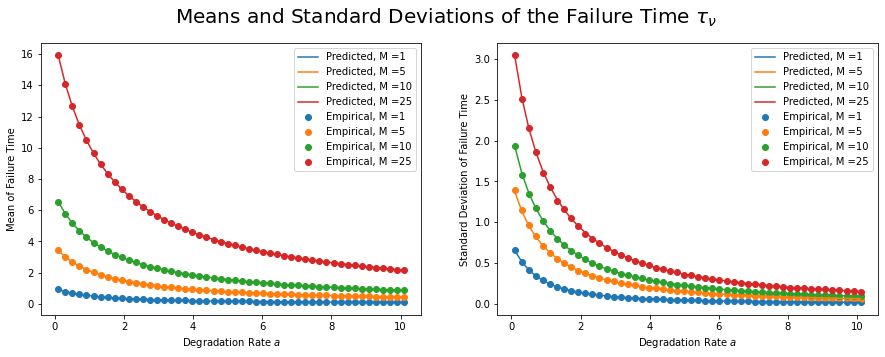

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5), sharex=True, sharey=False)

posVarLim = (2 * aSpace * mu * lam + mu ** 2) / (lam * (aSpace * lam + mu)) ** 2
timeVarLim = (2 * lam * mu * M * (aSpace * lam + mu) + mu * (mu - 4 * aSpace * lam)) / (aSpace * lam + mu) ** 4
probLim = aSpace * lam / (aSpace * lam + mu)

#ax1.plot(aSpace, lam * M / (aSpace * lam + mu), 'Xr')
#ax2.plot(aSpace, timeVarLim, 'Xr')

for i in range(mSteps):
    empiricalArray = np.array(empiricalCarrier[i])
    predictedArray = np.array(predictedCarrier[i])
    
    sLabel = 'Empirical, M =' + str(mList[i])
    pLabel = 'Predicted, M =' + str(mList[i])

    # mean crossing time
    ax1.scatter(aSpace, empiricalArray[:,2], label = sLabel)    
    ax1.plot(aSpace, predictedArray[:,2], label = pLabel)

    # standard deviation of crossing time
    ax2.scatter(aSpace, np.sqrt(empiricalArray[:,3]), label = sLabel)
    ax2.plot(aSpace, np.sqrt(predictedArray[:,3]), label = pLabel)
    
ax1.legend()
ax1.set_xlabel('Degradation Rate $a$')
ax1.set_ylabel('Mean of Failure Time')

ax2.legend()
ax2.set_xlabel('Degradation Rate $a$')
ax2.set_ylabel('Standard Deviation of Failure Time')

fig.suptitle(r'Means and Standard Deviations of the Failure Time $\tau_\nu$', fontsize = 20)

In [14]:
lam = 2
mu = 3

maxA = 5
maxM = 50

aSteps = 50

mList = [1, 5]

mSteps = len(mList)

aSpace = np.linspace(0.1, maxA + 0.1, aSteps)
mSpace = np.linspace(1, maxM + 1, mSteps)

empiricalCarrier = []
predictedCarrier = []

for M in mList:
    print('Threhold', M)
    
    empirical = []
    predicted = []
    
    for a in aSpace:
        print('Decay rate', a)

        results = []

        #print('Running simulations...')

        for i in range(1000000):
            results.append(simulatePath(a, lam, mu, M))
            # if i % 1000 == 0: print('Iteration', i)

        results = np.array(results)

        means = np.mean(results[:, [2, 4, 5]],0)
        var = np.var(results[:, [2, 4]], 0)

        empiricalResults = np.array([means[0], var[0], means[1], var[1], means[2]])

        empirical.append(empiricalResults)

        predictedResults = np.array([failureTimeMean(a, lam, mu, M),
                             failureTimeVariance(a, lam, mu, M),
                             failureDamageMean(a, lam, mu, M),
                             failureDamageVariance(a, lam, mu, M),
                             degradationProbability(a, lam, mu, M)])

        predicted.append(predictedResults)

        #print('Empirical Results', np.round(empiricalResults, 2))
        #print('Predicted Results', np.round(predictedResults, 2))
        
    # save the results from the previous step
    empiricalCarrier.append(empirical)
    predictedCarrier.append(predicted)

Threhold 1
Decay rate 0.1
Decay rate 0.20204081632653062
Decay rate 0.3040816326530612
Decay rate 0.4061224489795918
Decay rate 0.5081632653061224
Decay rate 0.610204081632653
Decay rate 0.7122448979591837
Decay rate 0.8142857142857143
Decay rate 0.9163265306122449
Decay rate 1.0183673469387755
Decay rate 1.1204081632653062
Decay rate 1.222448979591837
Decay rate 1.3244897959183675
Decay rate 1.426530612244898
Decay rate 1.5285714285714287
Decay rate 1.6306122448979594
Decay rate 1.73265306122449
Decay rate 1.8346938775510204
Decay rate 1.9367346938775512
Decay rate 2.038775510204082
Decay rate 2.1408163265306124
Decay rate 2.242857142857143
Decay rate 2.344897959183674
Decay rate 2.4469387755102043
Decay rate 2.548979591836735
Decay rate 2.6510204081632653
Decay rate 2.753061224489796
Decay rate 2.855102040816327
Decay rate 2.9571428571428573
Decay rate 3.059183673469388
Decay rate 3.1612244897959187
Decay rate 3.2632653061224492
Decay rate 3.3653061224489798
Decay rate 3.467346938775

Text(0.5, 0.98, 'Means and Standard Deviations of the Failure Damage $S_\\nu$')

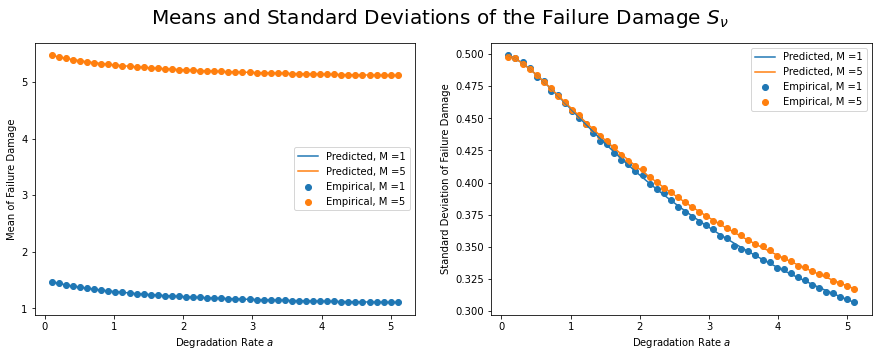

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5), sharex=True, sharey=False)

posVarLim = (2 * aSpace * mu * lam + mu ** 2) / (lam * (aSpace * lam + mu)) ** 2
timeVarLim = (2 * lam * mu * M * (aSpace * lam + mu) + mu * (mu - 4 * aSpace * lam)) / (aSpace * lam + mu) ** 4
probLim = aSpace * lam / (aSpace * lam + mu)

#ax1.plot(aSpace, lam * M / (aSpace * lam + mu), 'Xr')
#ax2.plot(aSpace, timeVarLim, 'Xr')

for i in range(mSteps):
    empiricalArray = np.array(empiricalCarrier[i])
    predictedArray = np.array(predictedCarrier[i])
    
    sLabel = 'Empirical, M =' + str(mList[i])
    pLabel = 'Predicted, M =' + str(mList[i])

    
    # mean crossing time
    ax1.scatter(aSpace, empiricalArray[:,0], label = sLabel)    
    ax1.plot(aSpace, predictedArray[:,0], label = pLabel)

    # standard deviation of crossing time
    ax2.scatter(aSpace, np.sqrt(empiricalArray[:,1]), label = sLabel)
    ax2.plot(aSpace, np.sqrt(predictedArray[:,1]), label = pLabel)
    
ax1.legend()
ax1.set_xlabel('Degradation Rate $a$')
ax1.set_ylabel('Mean of Failure Damage')

ax2.legend()
ax2.set_xlabel('Degradation Rate $a$')
ax2.set_ylabel('Standard Deviation of Failure Damage')

fig.suptitle(r'Means and Standard Deviations of the Failure Damage $S_\nu$', fontsize = 20)

In [18]:
lam = 2
mu = 1
a = 1

maxA = 10
maxM = 50

mSteps = 10

aSpace = [0.5, 1, 5]
aSteps = len(aSpace)

mSpace = np.linspace(0.5,3,mSteps)

empiricalCarrier = []
predictedCarrier = []

for a in aSpace:
    
    empirical = []
    predicted = []
    
    for M in mSpace:
        print('Threshold', M)

        results = []

        #print('Running simulations...')

        for i in range(10000):
            results.append(simulatePath(a, lam, mu, M))
            # if i % 1000 == 0: print('Iteration', i)

        results = np.array(results)

        means = np.mean(results[:, [2, 4, 5]],0)
        var = np.var(results[:, [2, 4]], 0)

        empiricalResults = np.array([means[0], var[0], means[1], var[1], means[2]])

        empirical.append(empiricalResults)

        predictedResults = np.array([failureTimeMean(a, lam, mu, M),
                             failureTimeVariance(a, lam, mu, M),
                             failureDamageMean(a, lam, mu, M),
                             failureDamageVariance(a, lam, mu, M),
                             degradationProbability(a, lam, mu, M)])

        print(predictedResults)
        predicted.append(predictedResults)

        #print('Empirical Results', np.round(empiricalResults, 2))
        #print('Predicted Results', np.round(predictedResults, 2))
        
    # save the results from the previous step
    empiricalCarrier.append(empirical)
    predictedCarrier.append(predicted)

Threshold 0.5
[0.71616618 0.16943836 0.71616618 0.07712746 0.56766764]
Threshold 0.7777777777777778
[1.01663992 0.18180702 1.01663992 0.20361586 0.52227571]
Threshold 1.0555555555555556
[1.30188905 0.1856533  1.30188905 0.3400472  0.50733301]
Threshold 1.3333333333333335
[1.58212635 0.18689505 1.58212635 0.47876142 0.50241397]
Threshold 1.6111111111111112
[1.86071378 0.18730118 1.86071378 0.61781243 0.50079466]
Threshold 1.8888888888888888
[2.13875809 0.18743458 2.13875809 0.75682814 0.5002616 ]
Threshold 2.166666666666667
[2.41662361 0.18747847 2.41662361 0.8957831  0.50008612]
Threshold 2.4444444444444446
[2.69443027 0.18749291 2.69443027 1.03470175 0.50002835]
Threshold 2.7222222222222223
[2.97221756 0.18749767 2.97221756 1.17360307 0.50000933]
Threshold 3.0
[3.24999846 0.18749923 3.24999846 1.31249693 0.50000307]
Threshold 0.5
[0.62947831 0.11271367 0.4196522  0.01397194 0.74104339]
Threshold 0.7777777777777778
[0.92828245 0.12785302 0.61885497 0.04187645 0.69899066]
Threshold 1.05

In [19]:
mSpace

array([0.5       , 0.77777778, 1.05555556, 1.33333333, 1.61111111,
       1.88888889, 2.16666667, 2.44444444, 2.72222222, 3.        ])

Text(0.5, 0.98, 'Probability of Degradation Failure')

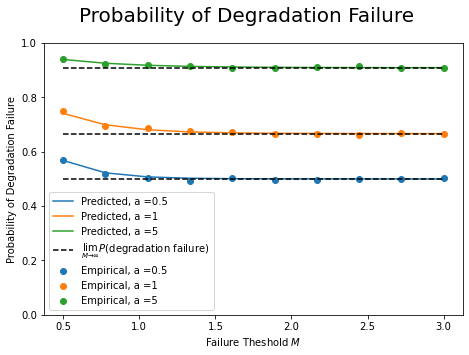

In [21]:
fig, (ax1) = plt.subplots(1, 1, figsize = (7.5, 5), sharex=True, sharey=False)

for i in range(aSteps):
    empiricalArray = np.array(empiricalCarrier[i])
    predictedArray = np.array(predictedCarrier[i])
    
    sLabel = 'Empirical, a =' + str(aSpace[i])
    pLabel = 'Predicted, a =' + str(aSpace[i])

    # probability of decay crossing
    ax1.scatter(mSpace, empiricalArray[:,4], label = sLabel)    
    ax1.plot(mSpace, predictedArray[:,4], label = pLabel)

# limiting probability
probLim = aSpace[0] * lam / (aSpace[0] * lam + mu)
ax1.plot(mSpace, mSteps * [probLim], '--', c = 'black',
         label = r'$\lim_{M\to\infty} P($degradation failure$)$')

probLim = aSpace[1] * lam / (aSpace[1] * lam + mu)
ax1.plot(mSpace, mSteps * [probLim], '--', c = 'black')

probLim = aSpace[2] * lam / (aSpace[2] * lam + mu)
ax1.plot(mSpace, mSteps * [probLim], '--', c = 'black')
    
#aArray = np.array(aSpace)
#probLim = aArray * lam / (aArray * lam + mu)

#ax2.plot(aSpace, timeVarLim, 'Xr')
#ax1.scatter(aSteps * [mSpace[-1]], probLim, c = 'black', marker = 'X',
#            label = r'$\lim_{M\to\infty} P($decay crossing$)$')

ax1.legend()
ax1.set_xlabel('Failure Theshold $M$')
ax1.set_ylabel('Probability of Degradation Failure')
ax1.set_ylim([0,1])

fig.suptitle(r'Probability of Degradation Failure', fontsize = 20)

In [29]:
#empirical_normed = (empiricalArray - empiricalArray.min(axis = 0)) / empiricalArray.ptp(axis = 0)

# Moments

Some code not used in our paper that can compute the first 10 moments of the time and damage at failure.

In [25]:
# Moments
def raw_moment(X, k, c=0):
    return ((X - c)**k).mean()

for i in range(1,11):
    print('Moment', i, 'of exit damage is', raw_moment(results[:,2], k = i))

for i in range(1,11):
    print('Moment', i, 'of exit time is', raw_moment(results[:,4], k = i))

Moment 1 of exit damage is 3.0460785341916576
Moment 2 of exit damage is 9.322734641242105
Moment 3 of exit damage is 28.728854695642983
Moment 4 of exit damage is 89.42319322798255
Moment 5 of exit damage is 282.50388783252083
Moment 6 of exit damage is 912.2278279250938
Moment 7 of exit damage is 3040.5360570766343
Moment 8 of exit damage is 10591.676102385652
Moment 9 of exit damage is 39082.03991705019
Moment 10 of exit damage is 154433.83396898423
Moment 1 of exit time is 0.5534891622688131
Moment 2 of exit time is 0.3128495759911426
Moment 3 of exit time is 0.17917622074654538
Moment 4 of exit time is 0.10354556413086281
Moment 5 of exit time is 0.060229026087673686
Moment 6 of exit time is 0.03520492001401676
Moment 7 of exit time is 0.020655976600253104
Moment 8 of exit time is 0.012156045037740083
Moment 9 of exit time is 0.007171211719920786
Moment 10 of exit time is 0.004238941491062183


In [26]:
lam = 2
mu = 3

maxA = 5
maxM = 50

aSteps = 50

mList = [1, 5, 10, 25]

mSteps = len(mList)

aSpace = np.linspace(0.1, maxA + 0.1, aSteps)
mSpace = np.linspace(1, maxM + 1, mSteps)

empiricalCarrier = []
predictedCarrier = []

for M in mList:
    print('Threhold', M)
    
    empirical = []
    predicted = []
    
    for a in aSpace:
        print('Decay rate', a)

        results = []

        #print('Running simulations...')

        for i in range(10000):
            results.append(simulatePath(a, lam, mu, M))
            # if i % 1000 == 0: print('Iteration', i)

        results = np.array(results)

        means = np.mean(results[:, [2, 4, 5]],0)
        var = np.var(results[:, [2, 4]], 0)

        empiricalResults = np.array([means[0], var[0], means[1], var[1], means[2]])

        empirical.append(empiricalResults)

        predictedResults = np.array([failureTimeMean(a, lam, mu, M),
                             failureTimeVariance(a, lam, mu, M),
                             failureDamageMean(a, lam, mu, M),
                             failureDamageVariance(a, lam, mu, M),
                             degradationProbability(a, lam, mu, M)])

        predicted.append(predictedResults)

        #print('Empirical Results', np.round(empiricalResults, 2))
        #print('Predicted Results', np.round(predictedResults, 2))
        
    # save the results from the previous step
    empiricalCarrier.append(empirical)
    predictedCarrier.append(predicted)

Threhold 1
Decay rate 0.1
Decay rate 0.20204081632653062
Decay rate 0.3040816326530612
Decay rate 0.4061224489795918
Decay rate 0.5081632653061224
Decay rate 0.610204081632653
Decay rate 0.7122448979591837
Decay rate 0.8142857142857143
Decay rate 0.9163265306122449
Decay rate 1.0183673469387755
Decay rate 1.1204081632653062
Decay rate 1.222448979591837
Decay rate 1.3244897959183675
Decay rate 1.426530612244898
Decay rate 1.5285714285714287
Decay rate 1.6306122448979594
Decay rate 1.73265306122449
Decay rate 1.8346938775510204
Decay rate 1.9367346938775512
Decay rate 2.038775510204082
Decay rate 2.1408163265306124
Decay rate 2.242857142857143
Decay rate 2.344897959183674
Decay rate 2.4469387755102043
Decay rate 2.548979591836735
Decay rate 2.6510204081632653
Decay rate 2.753061224489796
Decay rate 2.855102040816327
Decay rate 2.9571428571428573
Decay rate 3.059183673469388
Decay rate 3.1612244897959187
Decay rate 3.2632653061224492
Decay rate 3.3653061224489798
Decay rate 3.467346938775